# Importing libraries




In [1]:
import jax
from flax import linen as nn
import idx2numpy
import matplotlib.pyplot as plt
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import grad, jit, random
import stax
import optax

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Converting Images arrays

In [2]:
train_images_path = 'train-images-idx3-ubyte'
train_labels_path = 'train-labels-idx1-ubyte'
test_images_path = 't10k-images-idx3-ubyte'
test_labels_path = 't10k-labels-idx1-ubyte'

train_images = idx2numpy.convert_from_file(train_images_path)
train_labels = idx2numpy.convert_from_file(train_labels_path)
test_images = idx2numpy.convert_from_file(test_images_path)
test_labels = idx2numpy.convert_from_file(test_labels_path)


# Visualizing some samples

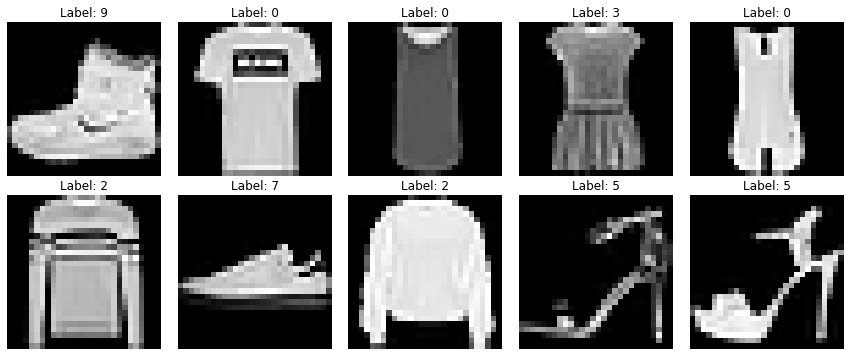

In [3]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.ravel()

for i in range(10):
    axes[i].imshow(train_images[i], cmap='gray')
    axes[i].set_title(f"Label: {train_labels[i]}")
    axes[i].axis('off')

plt.tight_layout()


# Label dictionnary

In [4]:
label_dict = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle_boot"
}


# Distribution of classes

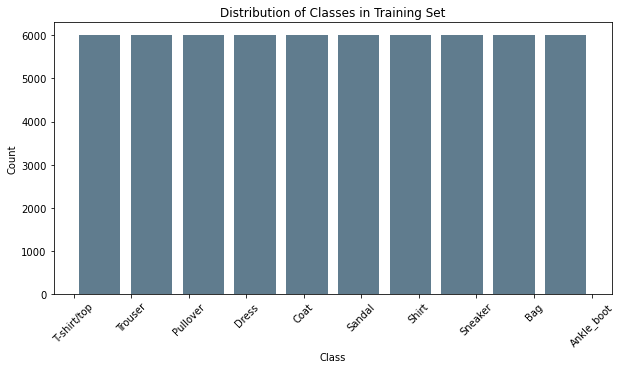

In [5]:
plt.figure(figsize=(10,5))
plt.hist(train_labels, bins=10, rwidth=0.8, color='#607c8e')
plt.title('Distribution of Classes in Training Set')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(list(label_dict.keys()), list(label_dict.values()), rotation=45)
plt.show()

# Preprocessing Fashion MNIST Dataset with JAX and TensorFlow


In [7]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
from jax import numpy as jnp
import numpy as np

(X_train, Y_train), (X_test, Y_test) = keras.datasets.fashion_mnist.load_data()

X_train, X_test = X_train.reshape(-1,28,28,1), X_test.reshape(-1,28,28,1)

X_train, X_test = jnp.array(X_train), jnp.array(X_test)

X_train, X_test = X_train/255.0, X_test/255.0

classes =  np.unique(Y_train)
class_labels = ["T-shirt/top","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]
mapping = dict(zip(classes, class_labels))

X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1), (60000,), (10000,))

# Defining a Simple CNN Model with Flax and JAX

In [8]:
from flax import linen
from jax import random

class CNN(linen.Module):
    def setup(self):
        self.conv1 = linen.Conv(features=32, kernel_size=(3,3), padding="SAME", name="CONV1")
        self.conv2 = linen.Conv(features=16, kernel_size=(3,3), padding="SAME", name="CONV2")
        self.linear1 = linen.Dense(len(classes), name="DENSE")

    def __call__(self, inputs):
        x = linen.relu(self.conv1(inputs))
        x = linen.relu(self.conv2(x))

        x = x.reshape((x.shape[0], -1))
        logits = self.linear1(x)

        return logits #linen.softmax(x)

In [9]:
seed = jax.random.PRNGKey(0)

model = CNN()
params = model.init(seed, X_train[:5])

for layer_params in params["params"].items():
    print("Layer Name : {}".format(layer_params[0]))
    weights, biases = layer_params[1]["kernel"], layer_params[1]["bias"]
    print("\tLayer Weights : {}, Biases : {}".format(weights.shape, biases.shape))

Layer Name : CONV1
	Layer Weights : (3, 3, 1, 32), Biases : (32,)
Layer Name : CONV2
	Layer Weights : (3, 3, 32, 16), Biases : (16,)
Layer Name : DENSE
	Layer Weights : (12544, 10), Biases : (10,)


In [10]:
preds = model.apply(params, X_train[:5])

preds.shape

(5, 10)

# Computing Cross Entropy Loss for CNN using JAX and Optax

In [11]:
def CrossEntropyLoss(weights, input_data, actual):
    logits = model.apply(weights, input_data)
    one_hot_actual = jax.nn.one_hot(actual, num_classes=len(classes))
    return optax.softmax_cross_entropy(logits, one_hot_actual).sum()

 # Training a Model in Mini-Batches with JAX, Optax, and Monitoring Validation Accuracy

In [12]:
from jax import value_and_grad
from tqdm import tqdm
from sklearn.metrics import accuracy_score

def TrainModelInBatches(X, Y, X_val, Y_val, epochs, weights, optimizer_state, batch_size=32):
    for i in range(1, epochs+1):
        batches = jnp.arange((X.shape[0]//batch_size)+1) ### Batch Indices

        losses = [] ## Record loss of each batch
        for batch in tqdm(batches):
            if batch != batches[-1]:
                start, end = int(batch*batch_size), int(batch*batch_size+batch_size)
            else:
                start, end = int(batch*batch_size), None

            X_batch, Y_batch = X[start:end], Y[start:end] ## Single batch of data

            loss, gradients = value_and_grad(CrossEntropyLoss)(weights, X_batch,Y_batch)

            ## Update Weights
            updates, optimizer_state = optimizer.update(gradients, optimizer_state)
            weights = optax.apply_updates(weights, updates)

            losses.append(loss) ## Record Loss

        print("CrossEntropyLoss : {:.3f}".format(jnp.array(losses).mean()))

        Y_val_preds = model.apply(weights, X_val)
        val_acc = accuracy_score(Y_val, jnp.argmax(Y_val_preds, axis=1))
        print("Validation  Accuracy : {:.3f}".format(val_acc))

    return weights

In [13]:
seed = random.PRNGKey(0)
batch_size=256
epochs=5
learning_rate = jnp.array(1/1e4)

model = CNN()
weights = model.init(seed, X_train[:5])

optimizer = optax.adam(learning_rate=learning_rate) ## Initialize SGD Optimizer
optimizer_state = optimizer.init(weights)

final_weights = TrainModelInBatches(X_train, Y_train, X_test, Y_test, epochs, weights, optimizer_state, batch_size=batch_size)

100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [02:22<00:00,  1.65it/s]


CrossEntropyLoss : 214.524
Validation  Accuracy : 0.819


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [02:13<00:00,  1.76it/s]


CrossEntropyLoss : 114.644
Validation  Accuracy : 0.844


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [02:14<00:00,  1.74it/s]


CrossEntropyLoss : 102.939
Validation  Accuracy : 0.853


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [02:13<00:00,  1.76it/s]


CrossEntropyLoss : 96.734
Validation  Accuracy : 0.861


100%|████████████████████████████████████████████████████████████████████████████████| 235/235 [02:14<00:00,  1.75it/s]


CrossEntropyLoss : 92.434
Validation  Accuracy : 0.866


# Evaluating Model Performance on Test Data using Classification Metrics

In [14]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

Y_test_preds = model.apply(final_weights, X_test)
Y_test_preds = jnp.argmax(Y_test_preds, axis=1)

print("Test Accuracy : {}".format(accuracy_score(Y_test, Y_test_preds)))
print("\nConfusion Matrix : ")
print(confusion_matrix(Y_test, Y_test_preds))
print("\nClassification Report :")
print(classification_report(Y_test, Y_test_preds, target_names=class_labels))

Test Accuracy : 0.8655

Confusion Matrix : 
[[882   0  15  35   8   3  45   0  12   0]
 [  4 963   4  21   3   0   3   0   2   0]
 [ 25   0 797  10 112   1  50   0   5   0]
 [ 38  10   6 893  35   0  17   0   1   0]
 [  1   1  85  31 830   0  48   0   4   0]
 [  0   0   0   1   0 955   0  26   1  17]
 [209   1 108  29 131   1 508   0  13   0]
 [  0   0   0   0   0  37   0 902   1  60]
 [  4   0   5   9   4   1  13   5 959   0]
 [  0   0   0   0   0   4   1  28   1 966]]

Classification Report :
              precision    recall  f1-score   support

 T-shirt/top       0.76      0.88      0.82      1000
     Trouser       0.99      0.96      0.98      1000
    Pullover       0.78      0.80      0.79      1000
       Dress       0.87      0.89      0.88      1000
        Coat       0.74      0.83      0.78      1000
      Sandal       0.95      0.95      0.95      1000
       Shirt       0.74      0.51      0.60      1000
     Sneaker       0.94      0.90      0.92      1000
         Bag 